# Analyzing Key Factors in Sudoku Puzzle Difficulty


### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Flatten

### Load Dataset

In [2]:
df = pd.read_csv("sudoku.csv")

### Basic Statistics

In [3]:
# There are 3 million samples with 5 features
df.shape

(3000000, 5)

In [4]:
df.head()

,id,puzzle,solution,clues,difficulty
0,1,1..5.37..6.3..8.9......98...1.......8761.........,1985437266432785915276198439147352688761924352...,27,2.2
1,2,...81.....2........1.9..7...7..25.934.2..........,9348172567286534196159427381764258934523981673...,23,0.0
2,3,..5...74.3..6...19.....1..5...7...2.9....58..7...,2159837463876542194692713855387169249413258677...,25,2.6
3,4,........5.2...9....9..2...373..481.....36....5...,4738169256285397411954278637329481569413652785...,26,1.4
4,5,.4.1..............653.....1.8.9..74...24..91.....,9471536821286493576532874913819267455724389164...,25,1.1


In [5]:
df.tail()

,id,puzzle,solution,clues,difficulty
2999995,2999996,7..........2......9.6.28.1....28..3.......5.4....,7834512964129768539563284175712846392691375848...,23,5.0
2999996,2999997,.5......2...58...1..7..16....2...4...849.3...9...,1594368722465879318372916543126754896849237159...,24,4.1
2999997,2999998,.....9.48...6..3....4.87.5...71.2..5.....6..9....,1735296482856413976943872514371928655218764399...,25,0.0
2999998,2999999,......23....8..796..5.......987.1....342.59..6...,8764192354138527969253761842987416531342659786...,24,0.0
2999999,3000000,7.4..6.8.6....85.4.9........1..........2.54......,7541369826237985141984526734153697288762154399...,24,1.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          int64  
 1   puzzle      object 
 2   solution    object 
 3   clues       int64  
 4   difficulty  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 114.4+ MB


In [7]:
df.describe()

,id,clues,difficulty
count,3.000000e+06,3.000000e+06,3.000000e+06
mean,1.500000e+06,2.430547e+01,1.238623e+00
std,8.660255e+05,1.102716e+00,1.272755e+00
min,1.000000e+00,1.900000e+01,0.000000e+00
25%,7.500008e+05,2.400000e+01,0.000000e+00
50%,1.500000e+06,2.400000e+01,1.200000e+00
75%,2.250000e+06,2.500000e+01,2.200000e+00
max,3.000000e+06,3.100000e+01,8.500000e+00


In [8]:
# There are no missing values
df.isnull().sum()

id            0
puzzle        0
solution      0
clues         0
difficulty    0
dtype: int64

### Empty Places Distribution
We can see that the number of empty spaces in a puzzle is somewhat normally distributed and centered at about 57. The vast majority of empty places are between 53 and 60.

In [9]:
df["empty_places"] = df["puzzle"].apply(lambda x: x.count("."))
df.head()

,id,puzzle,solution,clues,difficulty,empty_places
0,1,1..5.37..6.3..8.9......98...1.......8761.........,1985437266432785915276198439147352688761924352...,27,2.2,54
1,2,...81.....2........1.9..7...7..25.934.2..........,9348172567286534196159427381764258934523981673...,23,0.0,58
2,3,..5...74.3..6...19.....1..5...7...2.9....58..7...,2159837463876542194692713855387169249413258677...,25,2.6,56
3,4,........5.2...9....9..2...373..481.....36....5...,4738169256285397411954278637329481569413652785...,26,1.4,55
4,5,.4.1..............653.....1.8.9..74...24..91.....,9471536821286493576532874913819267455724389164...,25,1.1,56


57    1058407
56     865548
58     556412
55     327826
59     115931
54      61228
60       8204
53       5926
52        297
61        210
51          9
50          1
62          1
Name: empty_places, dtype: int64


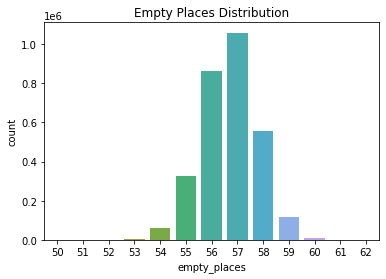

In [10]:
print(df.empty_places.value_counts())
sns.countplot(data=df, x="empty_places")
plt.title("Empty Places Distribution")
plt.show()

In [11]:
# Count number of empty places per row
def empty_places_per_row(puzzle):
    row = []
    count = 0
    for i in range(81):
        if (puzzle[i] == '.'):
            count += 1

    if ((i+1)%9 == 0):
        row.append(count)
        count = 0

    return row

In [12]:
# Create count of empty per row feature
df["empty_per_row"] = df["puzzle"].apply(empty_places_per_row)
df.head()

,id,puzzle,solution,clues,difficulty,empty_places,empty_per_row
0,1,1..5.37..6.3..8.9......98...1.......8761.........,1985437266432785915276198439147352688761924352...,27,2.2,54,[54]
1,2,...81.....2........1.9..7...7..25.934.2..........,9348172567286534196159427381764258934523981673...,23,0.0,58,[58]
2,3,..5...74.3..6...19.....1..5...7...2.9....58..7...,2159837463876542194692713855387169249413258677...,25,2.6,56,[56]
3,4,........5.2...9....9..2...373..481.....36....5...,4738169256285397411954278637329481569413652785...,26,1.4,55,[55]
4,5,.4.1..............653.....1.8.9..74...24..91.....,9471536821286493576532874913819267455724389164...,25,1.1,56,[56]


In [13]:
# Create standard deviation feature
df["empty_per_row_std"] = df["empty_per_row"].apply(lambda x: np.std(x))

In [14]:
# Create mean feature
df["empty_per_row_mean"] = df["empty_per_row"].apply(lambda x: np.mean(x))

In [15]:
# Create mode feature
df["empty_per_row_mode"] = df["empty_per_row"].apply(lambda x: max(x, key=x.count))
df.head()

,id,puzzle,solution,clues,difficulty,empty_places,empty_per_row,empty_per_row_std,empty_per_row_mean,empty_per_row_mode
0,1,1..5.37..6.3..8.9......98...1.......8761.........,1985437266432785915276198439147352688761924352...,27,2.2,54,[54],0.0,54.0,54
1,2,...81.....2........1.9..7...7..25.934.2..........,9348172567286534196159427381764258934523981673...,23,0.0,58,[58],0.0,58.0,58
2,3,..5...74.3..6...19.....1..5...7...2.9....58..7...,2159837463876542194692713855387169249413258677...,25,2.6,56,[56],0.0,56.0,56
3,4,........5.2...9....9..2...373..481.....36....5...,4738169256285397411954278637329481569413652785...,26,1.4,55,[55],0.0,55.0,55
4,5,.4.1..............653.....1.8.9..74...24..91.....,9471536821286493576532874913819267455724389164...,25,1.1,56,[56],0.0,56.0,56


57.0    1058407
56.0     865548
58.0     556412
55.0     327826
59.0     115931
54.0      61228
60.0       8204
53.0       5926
52.0        297
61.0        210
51.0          9
50.0          1
62.0          1
Name: empty_per_row_mean, dtype: int64


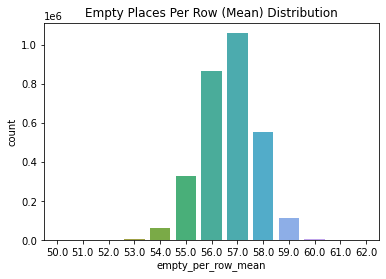

In [16]:
print(df["empty_per_row_mean"].value_counts())
sns.countplot(data=df, x="empty_per_row_mean")
plt.title("Empty Places Per Row (Mean) Distribution")
plt.show()

57    1058407
56     865548
58     556412
55     327826
59     115931
54      61228
60       8204
53       5926
52        297
61        210
51          9
50          1
62          1
Name: empty_per_row_mode, dtype: int64


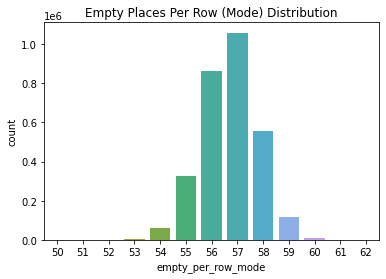

In [17]:
print(df["empty_per_row_mode"].value_counts())
sns.countplot(data=df, x="empty_per_row_mode")
plt.title("Empty Places Per Row (Mode) Distribution")
plt.show()

0.0    3000000
Name: empty_per_row_std, dtype: int64


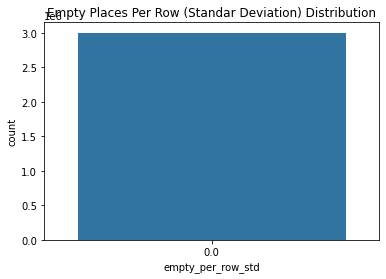

In [18]:
print(df["empty_per_row_std"].value_counts())
sns.countplot(data=df, x="empty_per_row_std")
plt.title("Empty Places Per Row (Standar Deviation) Distribution")
plt.show()

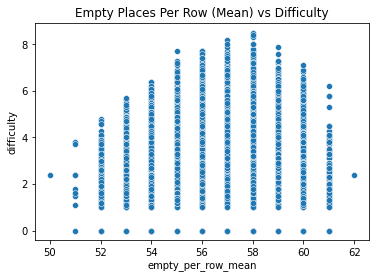

In [19]:
sns.scatterplot(data=df, x="empty_per_row_mean", y="difficulty")
plt.title("Empty Places Per Row (Mean) vs Difficulty")
plt.show()

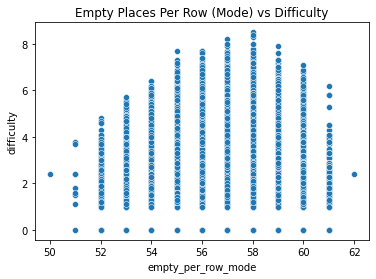

In [20]:
sns.scatterplot(data=df, x="empty_per_row_mode", y="difficulty")
plt.title("Empty Places Per Row (Mode) vs Difficulty")
plt.show()

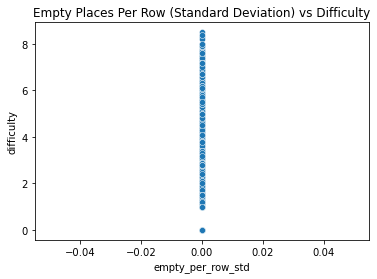

In [21]:
sns.scatterplot(data=df, x="empty_per_row_std", y="difficulty")
plt.title("Empty Places Per Row (Standard Deviation) vs Difficulty")
plt.show()

### Clue Distribution
We can see that the clues feature is somewhat normally distributed and centered at about 24. The vast majority of clues are between 23 and 26.

24    1058407
25     865548
23     556412
26     327826
22     115931
27      61228
21       8204
28       5926
29        297
20        210
30          9
31          1
19          1
Name: clues, dtype: int64


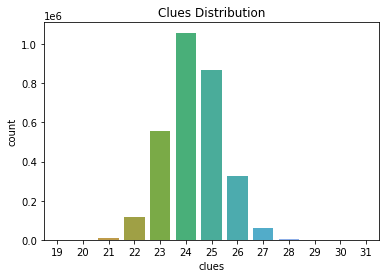

In [22]:
print(df["clues"].value_counts())
sns.countplot(data=df, x="clues")
plt.title("Clues Distribution")
plt.show()

### Difficulty Distribution
We can see that the difficulty feature is very right skewed. The vast majority of difficulties are 0. Generally, as the difficulty increases, there are less samples. This may make it difficult to find patterns for higher difficulties because there are very little samples to train on.

Counts:
 0.0    1294081
1.0      91570
1.4      85081
1.5      84909
1.6      83935
        ...   
8.5          1
7.8          1
8.3          1
8.2          1
8.4          1
Name: difficulty, Length: 76, dtype: int64

More than 100 instances:
 0.0    1294081
1.0      91570
1.4      85081
1.5      84909
1.6      83935
1.3      83737
1.7      81066
1.2      78932
1.8      78911
1.9      76141
2.0      73067
2.1      70059
1.1      68137
2.2      66185
2.3      62485
2.4      58971
2.5      55218
2.6      51266
2.7      48165
2.8      45056
2.9      40702
3.0      37421
3.1      34114
3.2      31191
3.3      27770
3.4      25096
3.5      22476
3.6      20098
3.7      17528
3.8      15585
3.9      13623
4.0      11795
4.1      10226
4.2       9016
4.3       7607
4.4       6510
4.5       5607
4.6       4651
4.7       3970
4.8       3258
4.9       2762
5.0       2236
5.1       1930
5.2       1544
5.3       1200
5.4       1027
5.5        794
5.6        639
5.7        554
5.8        425
5.9   

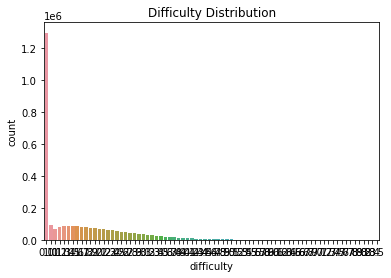

In [23]:
difficulties = df["difficulty"].value_counts()
print("Counts:\n", difficulties)
print()
print("More than 100 instances:\n", difficulties.loc[difficulties > 100])
sns.countplot(data=df, x="difficulty")
plt.title("Difficulty Distribution")
plt.show()

### Difficulty Distribution Per Clues
The difficulty distributions per each clue count with significant sample counts are still very similarly right skewed like the overall distribution, so the number of clues is not a good indicator of difficulty.

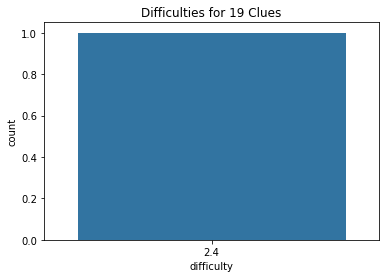

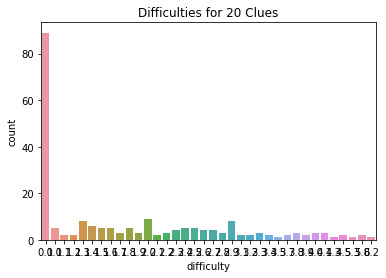

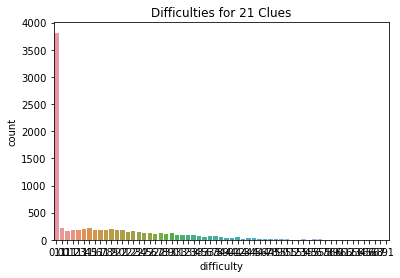

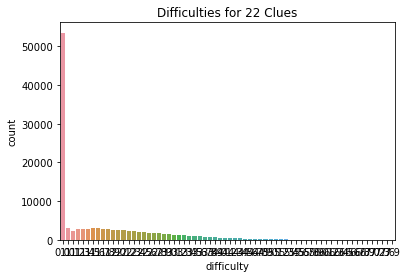

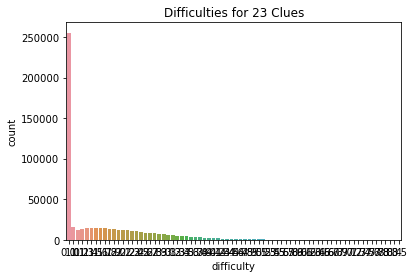

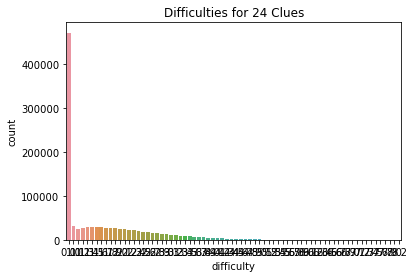

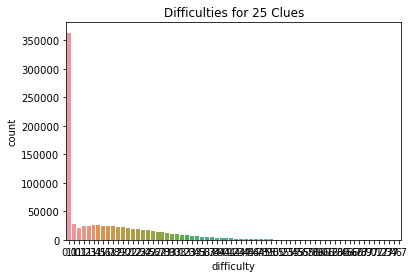

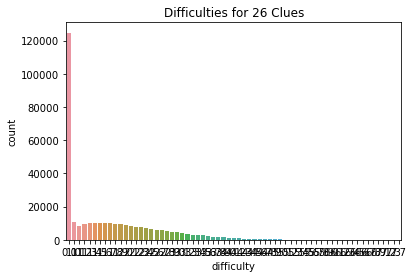

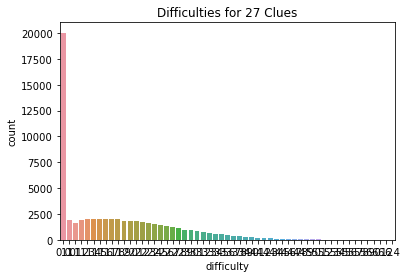

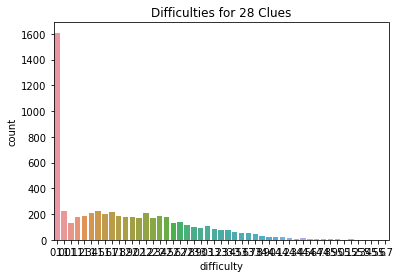

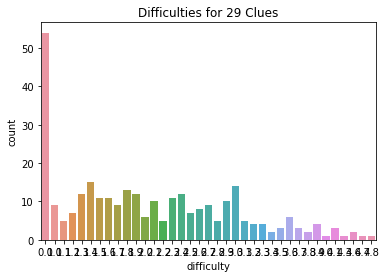

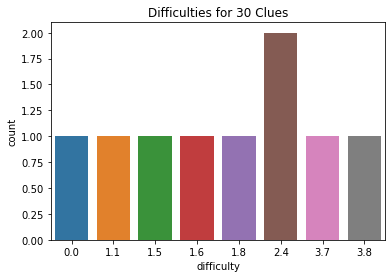

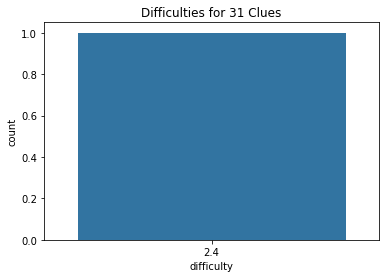

In [24]:
# Plot for each unique clue value
for clue in sorted(df["clues"].unique()):
    clue_df = df[df["clues"] == clue]
    sns.countplot(data=clue_df, x="difficulty")
    plt.title(f"Difficulties for {clue} Clues")
    plt.show()

### Clues Distribution Per Difficulty
All difficulties have nearly the same clues distribution shape, so again the number of clues is not a good indicator of difficulty.

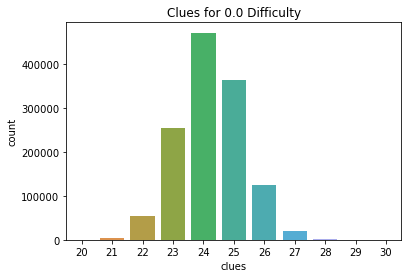

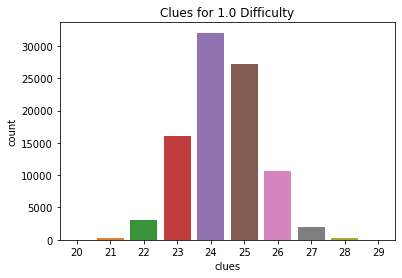

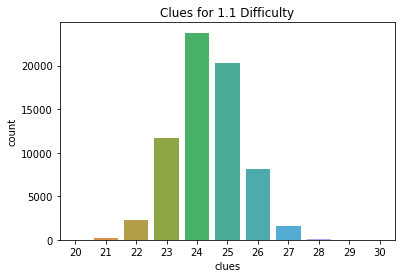

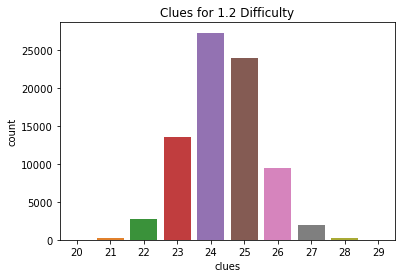

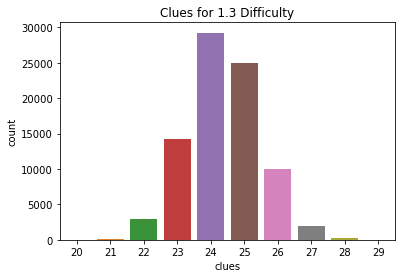

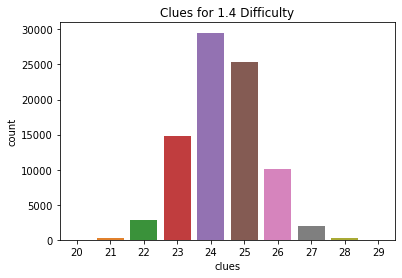

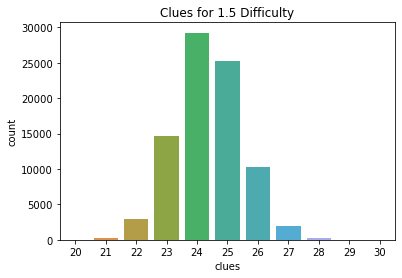

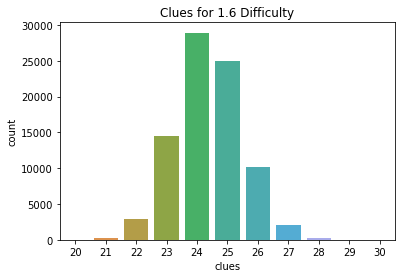

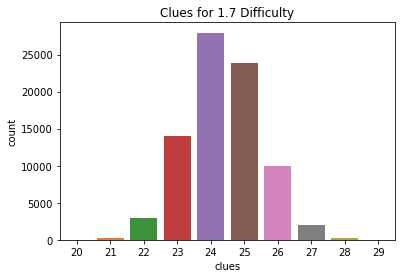

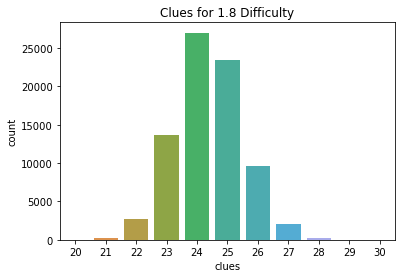

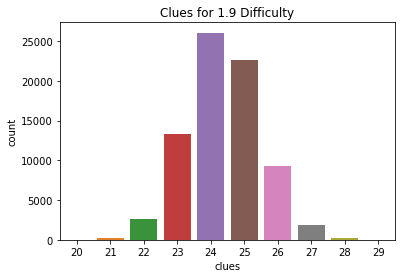

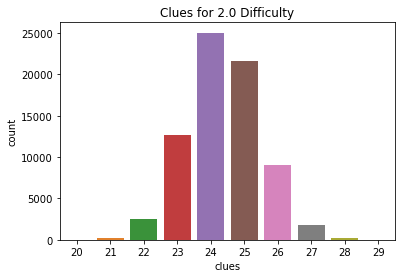

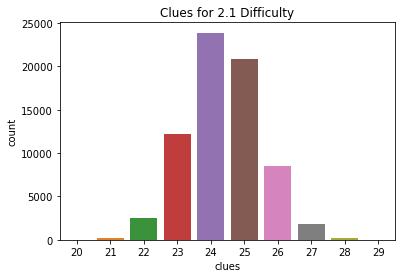

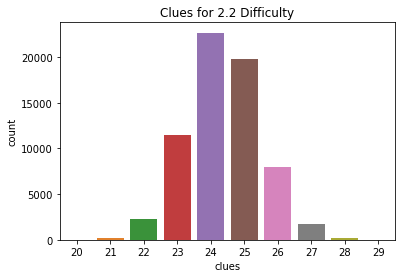

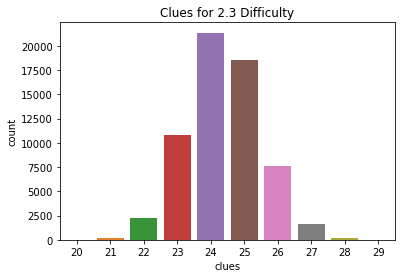

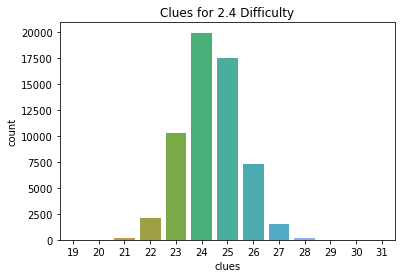

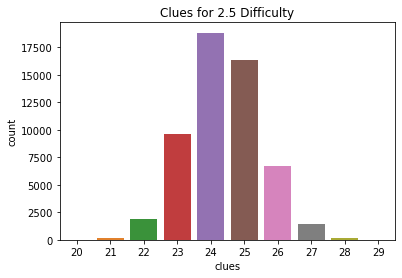

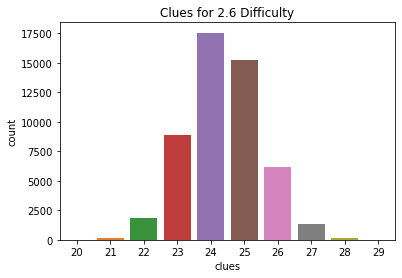

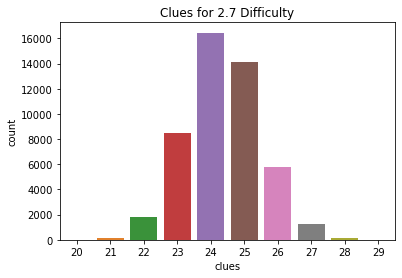

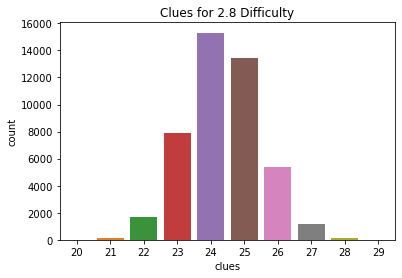

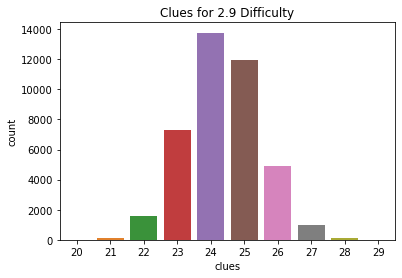

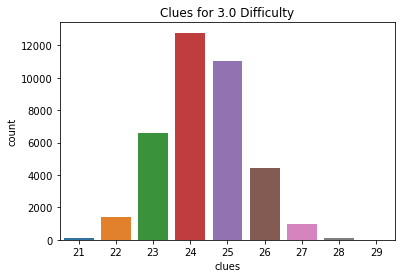

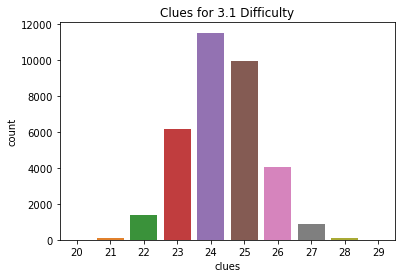

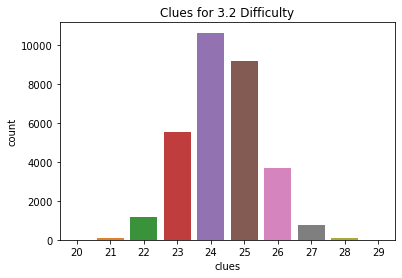

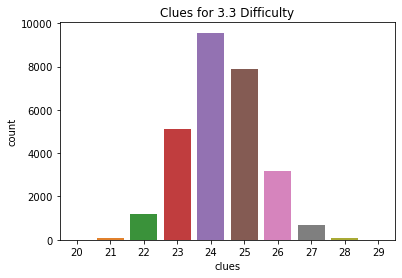

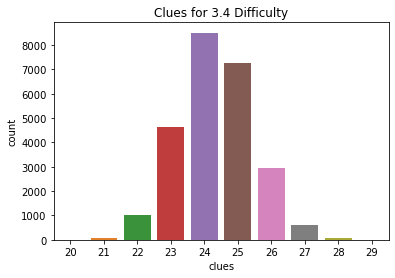

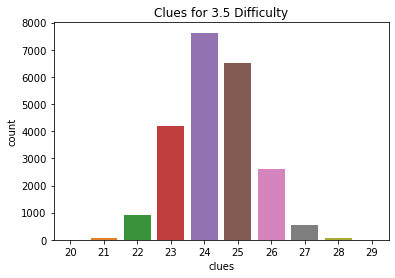

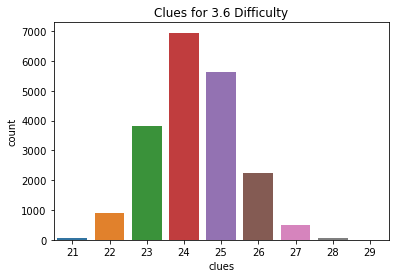

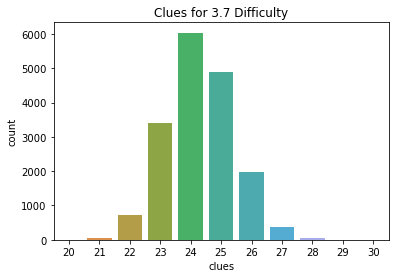

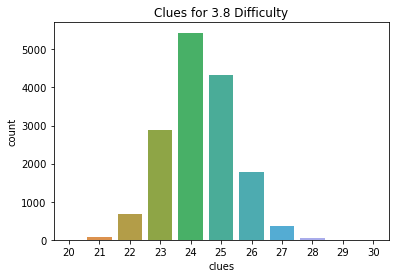

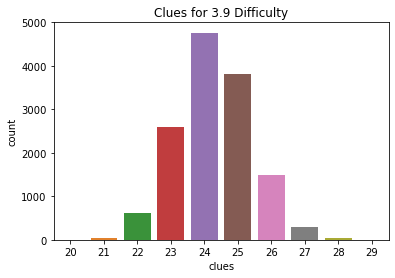

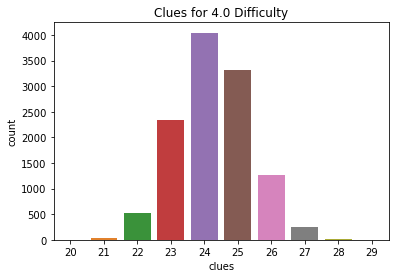

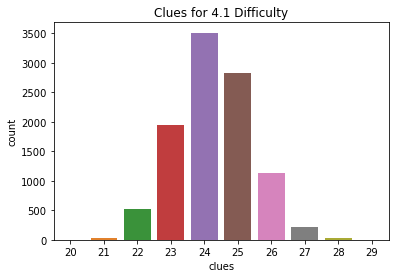

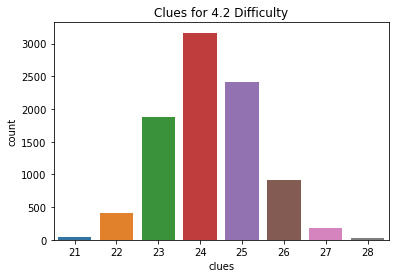

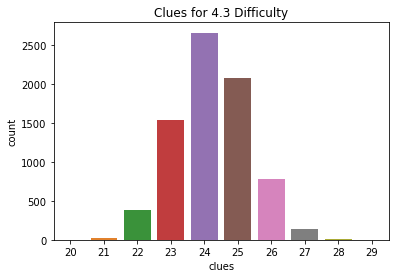

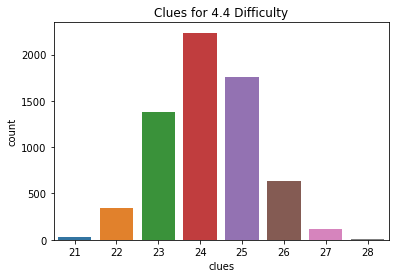

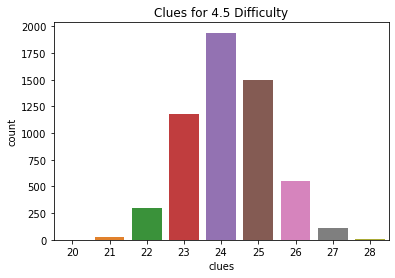

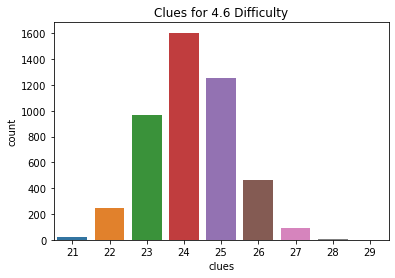

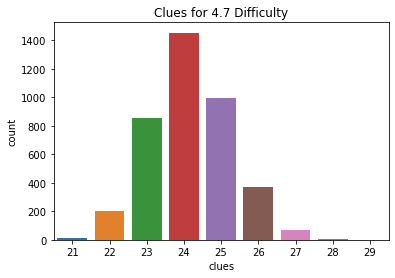

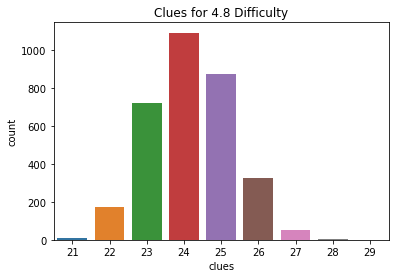

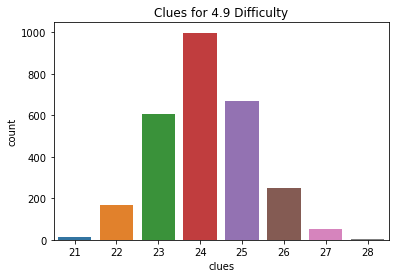

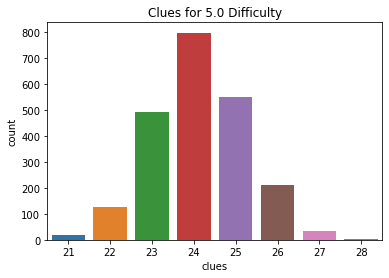

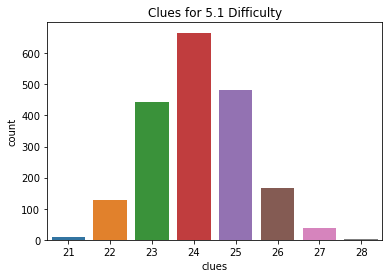

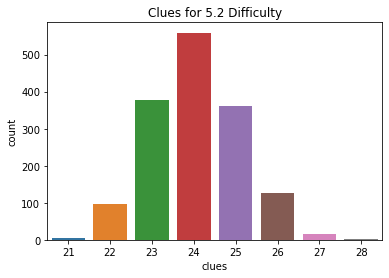

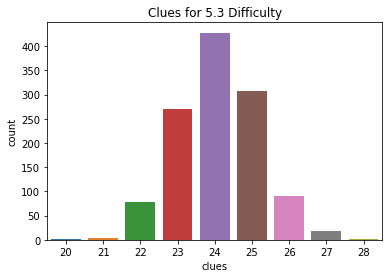

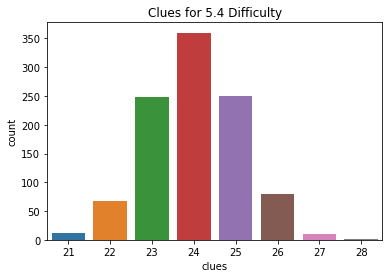

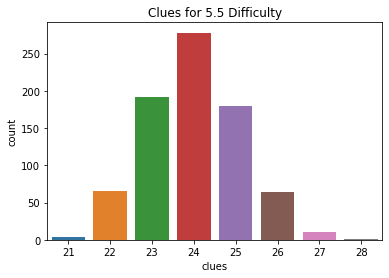

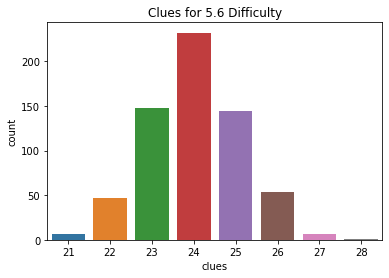

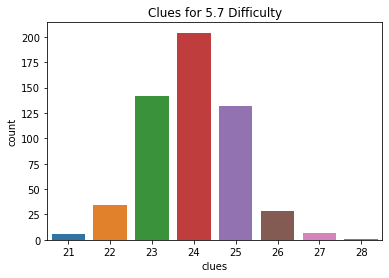

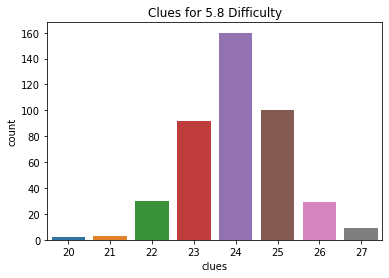

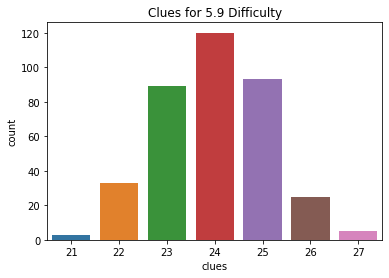

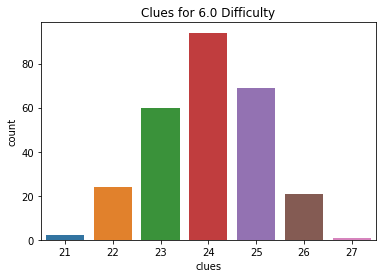

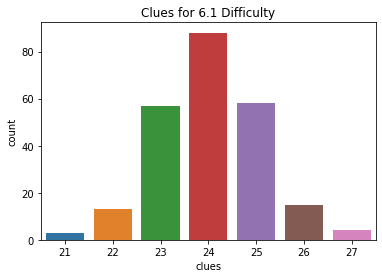

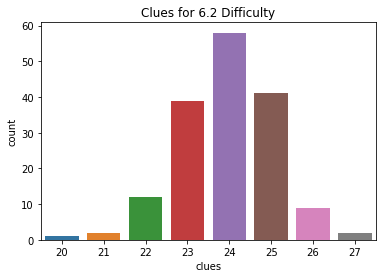

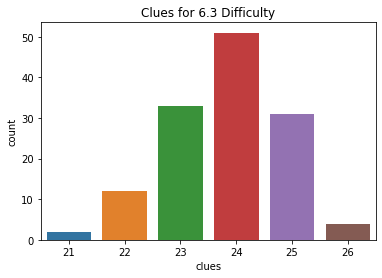

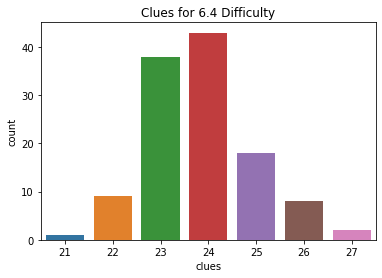

In [25]:
# Only plot for difficulty counts greater than 100
difficulty_counts = df["difficulty"].value_counts()
difficulty_counts = difficulty_counts.loc[difficulty_counts > 100]
for difficulty in sorted(difficulty_counts.index):
    difficulty_df = df[df["difficulty"] == difficulty]
    sns.countplot(data=difficulty_df, x="clues")
    plt.title(f"Clues for {difficulty} Difficulty")
    plt.show()

### Reduce Zero Difficulty Samples
- There are more than 1 million samples with zero difficulty
- Reducing the number of zero difficulty samples to 100,000

In [26]:
n_drop = len(df[df["difficulty"] == 0]) - 100000
df = df.drop(df[df["difficulty"] == 0].sample(n_drop, random_state=1).index)
df

,id,puzzle,solution,clues,difficulty,empty_places,empty_per_row,empty_per_row_std,empty_per_row_mean,empty_per_row_mode
0,1,1..5.37..6.3..8.9......98...1.......8761.........,1985437266432785915276198439147352688761924352...,27,2.2,54,[54],0.0,54.0,54
2,3,..5...74.3..6...19.....1..5...7...2.9....58..7...,2159837463876542194692713855387169249413258677...,25,2.6,56,[56],0.0,56.0,56
3,4,........5.2...9....9..2...373..481.....36....5...,4738169256285397411954278637329481569413652785...,26,1.4,55,[55],0.0,55.0,55
4,5,.4.1..............653.....1.8.9..74...24..91.....,9471536821286493576532874913819267455724389164...,25,1.1,56,[56],0.0,56.0,56
7,8,38.1.........5.6.....9....3.4.........5.18.......,3861729544198536725279468137413652986952184372...,25,3.7,56,[56],0.0,56.0,56
...,...,...,...,...,...,...,...,...,...,...
2999993,2999994,2......8.........6....82.97.431...2.8..3.........,2794635815387192464165823979431567288273946151...,25,0.0,56,[56],0.0,56.0,56
2999994,2999995,...3...61..4.......5....4.22.8...3....9.1.82.....,8273549611942765383561984722784653195697138244...,24,1.5,57,[57],0.0,57.0,57
2999995,2999996,7..........2......9.6.28.1....28..3.......5.4....,7834512964129768539563284175712846392691375848...,23,5.0,58,[58],0.0,58.0,58
2999996,2999997,.5......2...58...1..7..16....2...4...849.3...9...,1594368722465879318372916543126754896849237159...,24,4.1,57,[57],0.0,57.0,57


In [27]:
print("Total record count:", len(df))
print("Records with zero difficulty:", len(df[df["difficulty"] == 0]))

Total record count: 1805919
Records with zero difficulty: 100000


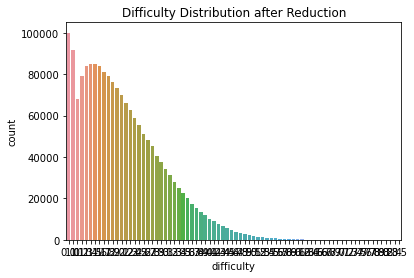

In [28]:
sns.countplot(data=df, x="difficulty")
plt.title("Difficulty Distribution after Reduction")
plt.show()

### Data Cleaning
- Remove "id" feature
- Convert periods in "puzzle" feature to zeros
- Split "puzzle" feature into 81 individual features

In [29]:
# Remove "id" feature
df = df.drop(columns=["id"])
df.head()

,puzzle,solution,clues,difficulty,empty_places,empty_per_row,empty_per_row_std,empty_per_row_mean,empty_per_row_mode
0,1..5.37..6.3..8.9......98...1.......8761.........,1985437266432785915276198439147352688761924352...,27,2.2,54,[54],0.0,54.0,54
2,..5...74.3..6...19.....1..5...7...2.9....58..7...,2159837463876542194692713855387169249413258677...,25,2.6,56,[56],0.0,56.0,56
3,........5.2...9....9..2...373..481.....36....5...,4738169256285397411954278637329481569413652785...,26,1.4,55,[55],0.0,55.0,55
4,.4.1..............653.....1.8.9..74...24..91.....,9471536821286493576532874913819267455724389164...,25,1.1,56,[56],0.0,56.0,56
7,38.1.........5.6.....9....3.4.........5.18.......,3861729544198536725279468137413652986952184372...,25,3.7,56,[56],0.0,56.0,56


In [30]:
# Convert periods in "puzzle" feature to zeros
df["puzzle"] = df["puzzle"].apply(lambda x: x.replace(".", "0"))
df.head()

,puzzle,solution,clues,difficulty,empty_places,empty_per_row,empty_per_row_std,empty_per_row_mean,empty_per_row_mode
0,1005037006030080900000098000100000008761000000...,1985437266432785915276198439147352688761924352...,27,2.2,54,[54],0.0,54.0,54
2,0050007403006000190000010050007000209000058007...,2159837463876542194692713855387169249413258677...,25,2.6,56,[56],0.0,56.0,56
3,0000000050200090000900200037300481000003600005...,4738169256285397411954278637329481569413652785...,26,1.4,55,[55],0.0,55.0,55
4,0401000000000000006530000010809007400024009100...,9471536821286493576532874913819267455724389164...,25,1.1,56,[56],0.0,56.0,56
7,3801000000000506000009000030400000000050180000...,3861729544198536725279468137413652986952184372...,25,3.7,56,[56],0.0,56.0,56


In [31]:
# Split "puzzle" feature into 81 individual features
X = df["puzzle"].str.split("", expand=True)
for i in range(81):
    df[f"x{i}"] = X[i + 1].astype(int)
df.head()

,puzzle,solution,clues,difficulty,empty_places,empty_per_row,empty_per_row_std,empty_per_row_mean,empty_per_row_mode,x0,...,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80
0,1005037006030080900000098000100000008761000000...,1985437266432785915276198439147352688761924352...,27,2.2,54,[54],0.0,54.0,54,1,...,4,7,0,0,0,6,0,3,1,2
2,0050007403006000190000010050007000209000058007...,2159837463876542194692713855387169249413258677...,25,2.6,56,[56],0.0,56.0,56,0,...,0,8,0,0,0,0,0,1,0,3
3,0000000050200090000900200037300481000003600005...,4738169256285397411954278637329481569413652785...,26,1.4,55,[55],0.0,55.0,55,0,...,0,0,0,9,7,8,0,0,0,2
4,0401000000000000006530000010809007400024009100...,9471536821286493576532874913819267455724389164...,25,1.1,56,[56],0.0,56.0,56,0,...,0,0,0,4,0,0,1,0,0,3
7,3801000000000506000009000030400000000050180000...,3861729544198536725279468137413652986952184372...,25,3.7,56,[56],0.0,56.0,56,3,...,6,0,0,4,0,8,0,0,2,0


### Relationship Between Clues and Difficulty - Linear Regression and Random Forest
There is not a clear cut relationship between clues and difficulty. I expected the relationship to clearly indicate that more clues results in lower difficulty. That is obviously not the case as seen from the plot. However, it can be noted that the maximum difficulty does somewhat have a relationship with clues. What surprised me was that the relationship was not monotonic. It seems the number of clues that results in the highest difficulty is 23. The max difficulty decreases as you increase the number of clues beyond 23. However, decreasing the number of clues below 23 also decreases the max difficulty, which I did not expect. Furthermore, training linear regression and random forest models using clues to predict difficulty yielded R squared values of nearly zero, further indicating that clues alone is not a good predictor for difficulty.

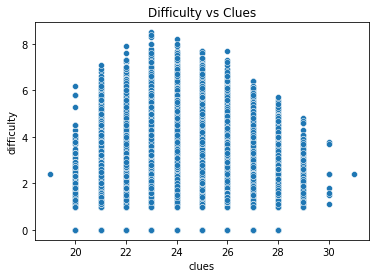

In [32]:
sns.scatterplot(data=df, x="clues", y="difficulty")
plt.title("Difficulty vs Clues")
plt.show()

In [33]:
# Using clues to predict difficulty
X = df["clues"].to_numpy().reshape(-1, 1)
y = df["difficulty"]

# Split data 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [34]:
def clues_vs_difficulty(model):
    # Train model
    model.fit(X_train, y_train)

    # Predict values for train and test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Print R squared scores
    print("Train R2:", r2_score(y_train, y_train_pred))
    print("Test R2:", r2_score(y_test, y_test_pred))

In [35]:
# Linear Regression
clues_vs_difficulty(LinearRegression())

Train R2: 0.00012090641728434992
Test R2: 0.00013240041415973902


In [36]:
# Random Forest
clues_vs_difficulty(RandomForestRegressor())

Train R2: 0.0004171001861137391
Test R2: 0.0005141950468893208


### Relationship Between Puzzle and Difficulty - Vanilla Neural Network
It seems a vanilla neural network cannot find any correlation between the raw puzzle and difficulty. It is very likely that the numbers themselves have no correlation towards difficulty, but rather whether or not they are occupied at all. Next, we try to convert all initial clues to the value one.

In [37]:
# Using puzzle values to predict difficulty
X = df.loc[:, [f"x{i}" for i in range(81)]]
y = df["difficulty"]

# Split data 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [38]:
# Train NN
model = Sequential()
model.add(InputLayer(input_shape=(81,)))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.summary()
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2624      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
45148/45148 [==============================] - 75s 2ms/step - loss: 1.0144
Epoch 2/2
45148/45148 [==============================] - 69s 2ms/step - loss: 1.0065


In [39]:
# Predict for train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# R squared values for train and test
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))

Train R2: -0.00017682842002919585
Test R2: -0.00013768404116754063


### Disregard Puzzle Values - Vanilla Neural Network
It seems a vanilla neural network cannot find any correlation between the puzzle and the difficulty, even after converting the clues to ones. Next, a convolutional neural network may be able to do better.

In [40]:
# Convert values to 1 and missing values to 0
for i in range(81):
    feature = f"x{i}"
    df[feature] = (df[feature] != 0).astype(int)
df

,puzzle,solution,clues,difficulty,empty_places,empty_per_row,empty_per_row_std,empty_per_row_mean,empty_per_row_mode,x0,...,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80
0,1005037006030080900000098000100000008761000000...,1985437266432785915276198439147352688761924352...,27,2.2,54,[54],0.0,54.0,54,1,...,1,1,0,0,0,1,0,1,1,1
2,0050007403006000190000010050007000209000058007...,2159837463876542194692713855387169249413258677...,25,2.6,56,[56],0.0,56.0,56,0,...,0,1,0,0,0,0,0,1,0,1
3,0000000050200090000900200037300481000003600005...,4738169256285397411954278637329481569413652785...,26,1.4,55,[55],0.0,55.0,55,0,...,0,0,0,1,1,1,0,0,0,1
4,0401000000000000006530000010809007400024009100...,9471536821286493576532874913819267455724389164...,25,1.1,56,[56],0.0,56.0,56,0,...,0,0,0,1,0,0,1,0,0,1
7,3801000000000506000009000030400000000050180000...,3861729544198536725279468137413652986952184372...,25,3.7,56,[56],0.0,56.0,56,1,...,1,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999993,2000000800000000060000820970431000208003000000...,2794635815387192464165823979431567288273946151...,25,0.0,56,[56],0.0,56.0,56,1,...,0,1,0,0,0,0,0,0,0,0
2999994,0003000610040000000500004022080003000090108200...,8273549611942765383561984722784653195697138244...,24,1.5,57,[57],0.0,57.0,57,0,...,0,0,0,1,0,0,1,0,1,0
2999995,7000000000020000009060280100002800300000005040...,7834512964129768539563284175712846392691375848...,23,5.0,58,[58],0.0,58.0,58,1,...,0,0,1,0,0,1,0,1,0,0
2999996,0500000020005800010070016000020004000849030009...,1594368722465879318372916543126754896849237159...,24,4.1,57,[57],0.0,57.0,57,0,...,1,0,0,0,0,0,1,0,0,0


In [41]:
# Using disregard puzzle values to predict difficulty
X = df.loc[:, [f"x{i}" for i in range(81)]]
y = df["difficulty"]

# Split data 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [42]:
# Train NN
model = Sequential()
model.add(InputLayer(input_shape=(81,)))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.summary()
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                2624      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
45148/45148 [==============================] - 73s 2ms/step - loss: 1.0114
Epoch 2/2
45148/45148 [==============================] - 71s 2ms/step - loss: 1.0045


In [43]:
# Predict for train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# R squared values for train and test
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))

Train R2: 0.0035752680292729933
Test R2: 0.0022251816695908477


### Convolutional Neural Network
Again, the results are not great and is not that much different than the vanilla neural network. Next, we try the same convolutional neural network again but disregarding the clue values.

In [44]:
# Reshape puzzle to 9x9x1 grid
puzzles = df["puzzle"].apply(lambda x: np.array([int(clue) for clue in x]).reshape(9,9,1))
puzzles

0          [[[1], [0], [0], [5], [0], [3], [7], [0], [0]]...
2          [[[0], [0], [5], [0], [0], [0], [7], [4], [0]]...
3          [[[0], [0], [0], [0], [0], [0], [0], [0], [5]]...
4          [[[0], [4], [0], [1], [0], [0], [0], [0], [0]]...
7          [[[3], [8], [0], [1], [0], [0], [0], [0], [0]]...
                                 ...                        
2999993    [[[2], [0], [0], [0], [0], [0], [0], [8], [0]]...
2999994    [[[0], [0], [0], [3], [0], [0], [0], [6], [1]]...
2999995    [[[7], [0], [0], [0], [0], [0], [0], [0], [0]]...
2999996    [[[0], [5], [0], [0], [0], [0], [0], [0], [2]]...
2999999    [[[7], [0], [4], [0], [0], [6], [0], [8], [0]]...
Name: puzzle, Length: 1805919, dtype: object

In [45]:
# Use puzzle values as input data
X = np.array(puzzles.values.tolist())
y = df["difficulty"].to_numpy()

# Split data 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [46]:
# Train CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(9, 9, 1)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.summary()
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 32)          320       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 2592)              0         
                                                                 
 dense_8 (Dense)             (None, 32)                82976     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 92,577
Trainable params: 92,577
Non-trainable params: 0
_________________________________________________________________
45148/45148 [==============================] - 366

In [47]:
# Predict for train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# R squared values for train and test
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))

Train R2: 0.007411511337147014
Test R2: 0.007321017741892533


### Disregarding Puzzle Values - Convolutional Neural Network
We are a little surprised that even this method failed to provide any positive results. There are many factors that could explain why we are not achieving the results we desire. It could be that our models are not complex enough to capture the true relationship between the puzzle and difficulty. It could also be that it is simply too hard to predict difficulty based on machine learning and data mining techniques. That could very well be the case because from our exploratory data analysis, there was incredible overlap between difficulties with very similar looking puzzles and numbers of clues.

In [48]:
# Convert numbers to 1 and missing values to 0 and reshape to 9x9x1 grid
puzzles = df["puzzle"].apply(lambda x: np.array([0 if clue == "0" else 1 for clue in x]).reshape(9,9,1))
puzzles

0          [[[1], [0], [0], [1], [0], [1], [1], [0], [0]]...
2          [[[0], [0], [1], [0], [0], [0], [1], [1], [0]]...
3          [[[0], [0], [0], [0], [0], [0], [0], [0], [1]]...
4          [[[0], [1], [0], [1], [0], [0], [0], [0], [0]]...
7          [[[1], [1], [0], [1], [0], [0], [0], [0], [0]]...
                                 ...                        
2999993    [[[1], [0], [0], [0], [0], [0], [0], [1], [0]]...
2999994    [[[0], [0], [0], [1], [0], [0], [0], [1], [1]]...
2999995    [[[1], [0], [0], [0], [0], [0], [0], [0], [0]]...
2999996    [[[0], [1], [0], [0], [0], [0], [0], [0], [1]]...
2999999    [[[1], [0], [1], [0], [0], [1], [0], [1], [0]]...
Name: puzzle, Length: 1805919, dtype: object

In [49]:
# Use disregarded puzzle values as input data
X = np.array(puzzles.values.tolist())
y = df["difficulty"].to_numpy()

# Split data 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [50]:
# Train CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(9, 9, 1)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.summary()
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 9, 9, 32)          320       
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 32)          9248      
                                                                 
 flatten_1 (Flatten)         (None, 2592)              0         
                                                                 
 dense_10 (Dense)            (None, 32)                82976     
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 92,577
Trainable params: 92,577
Non-trainable params: 0
_________________________________________________________________
45148/45148 [==============================] - 431

In [51]:
# Predict for train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# R squared values for train and test
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))

Train R2: 0.011870903209714068
Test R2: 0.011604112228076557
